# TalkingData: Fraudulent Click Prediction

In this notebook, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.

The analysis is divided into the following sections:
- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost
- Modelling building and evaluation: Gradient Boosting
- Modelling building and evaluation: XGBoost

## Understanding the Business Problem

<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [1]:
#pip install xgboost

In [2]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split,KFold,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier,plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

#### Reading the Data  

The code below reads the train_sample.csv file if you set testing = True, else reads the full train.csv file. You can read the sample while tuning the model etc., and then run the model on the full data once done.

#### Important Note: Save memory when the data is huge

Since the training data is quite huge, the program will be quite slow if you don't consciously follow some best practices to save memory. This notebook demonstrates some of those practices. 

In [3]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }


# As "train_csv" is around 9 GB we will take train_sample.csv

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_sample=pd.read_csv(train_path,skiprows=skiprows,nrows=nrows,usecols=colnames,dtype=dtypes)

In [4]:
train_sample.shape

(100000, 7)

In [5]:
train_sample.isnull().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

In [6]:
train_sample.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,30943.754230,12.04788,21.771250,22.818280,268.832460,0.002270
std,18651.939203,14.94150,259.667767,55.943136,129.724248,0.047591
min,8.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,14290.750000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,31117.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,46868.250000,15.00000,1.000000,19.000000,379.000000,0.000000
max,65526.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [7]:
# Displays memory consumed by each column ---
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [8]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


In [9]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [10]:
train_sample.head(5)

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


In [11]:
df=train_sample.copy()

In [12]:
## Counting unique value in columns 
for i in df.columns:
    print("For {}-- count is {}".format(i,len(df[i].unique())))

For ip-- count is 28470
For app-- count is 161
For device-- count is 100
For os-- count is 130
For channel-- count is 161
For click_time-- count is 80350
For is_attributed-- count is 2


In [13]:
df["is_attributed"].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [14]:
len(df["is_attributed"])

100000

In [15]:
df["is_attributed"][df["is_attributed"]==1].count()/len(df["is_attributed"])*100

0.22699999999999998

**download Rate is .227%**

Only about 0.2% of clicks are 'non-fraudulent', which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

In [16]:
# Lets check disstribution of variables
df.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'], dtype='object')

In [17]:
 df.groupby("is_attributed")["app"].mean()

is_attributed
0    12.001964
1    32.229075
Name: app, dtype: float64

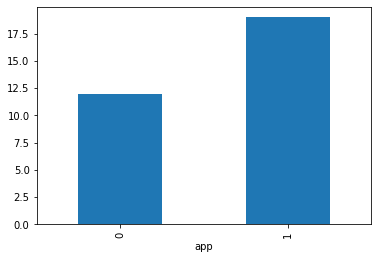

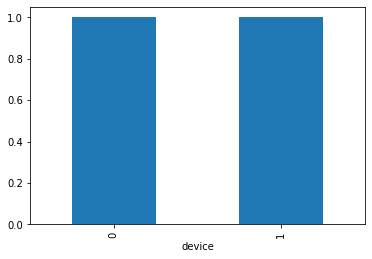

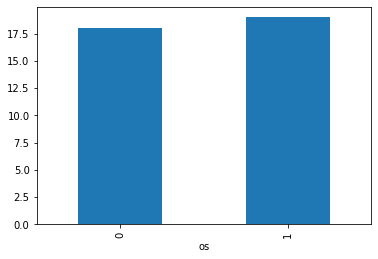

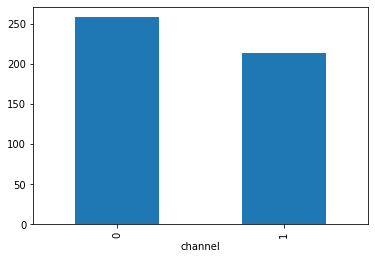

In [18]:
for i in ['app', 'device', 'os', 'channel']:
    df.groupby("is_attributed")[i].median().plot.bar()
    plt.xlabel(i)
    plt.show()

## Observatons
* Here using app people have downloaded more apps

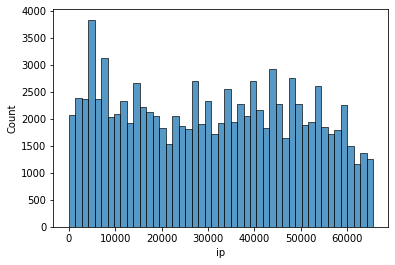

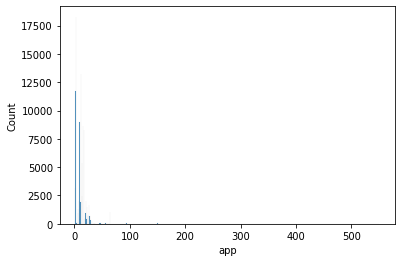

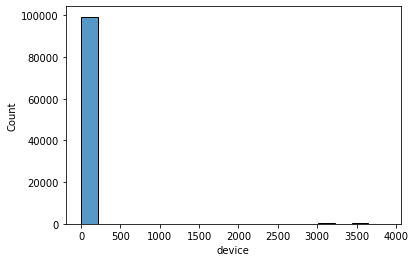

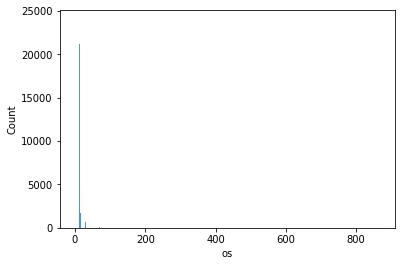

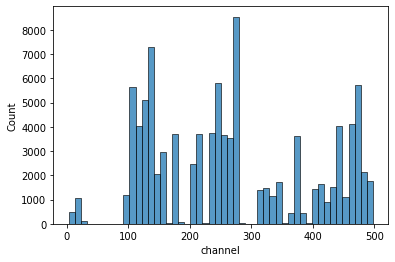

In [19]:
#plt.figure(figsize=(10,10))
for i in ['ip', 'app', 'device', 'os', 'channel']:
    sns.histplot(data=df,x=i)
    plt.show()

**distribution of 'app'**
1. some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)

**distribution of 'device'**
2. this is expected because a few popular devices are used heavily
3. channel: various channels get clicks in comparable quantities
4. os: there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 

In [20]:
from pandas_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [21]:
# plot the average of 'is_attributed', or 'download rate'
# with app (clearly this is non-readable)
app_target = df.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [22]:
fval=pd.DataFrame(df["app"].value_counts())
fval

,app
3,18279
12,13198
2,11737
9,8992
15,8595
...,...
145,1
97,1
96,1
267,1


In [23]:
fv=np.where(fval["app"]>50)
df1=df.iloc[fv]
df.iloc[fv].head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


<AxesSubplot:xlabel='count', ylabel='app'>

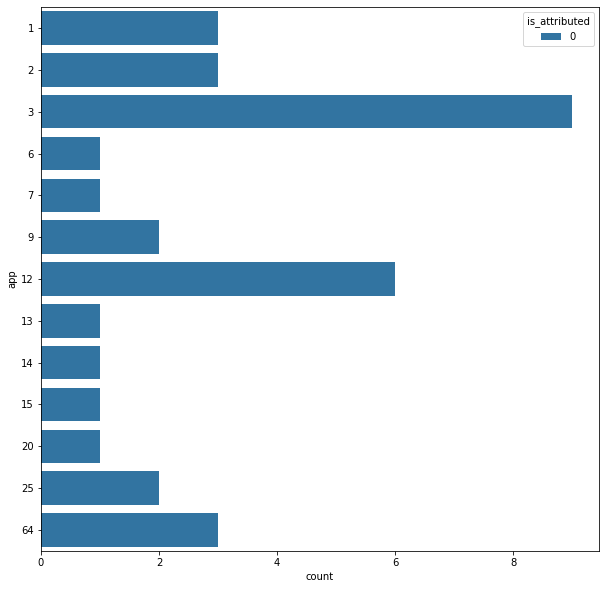

In [24]:
plt.figure(figsize=(10,10))
sns.countplot(data=df1,y="app",hue="is_attributed")

# Another way to do is below-
As in graph above we were not able to seee count properly

In [25]:
fre_app=df.groupby("app").size()
fre_app

app
1       3135
2      11737
3      18279
4         58
5        188
       ...  
486        1
536        1
538        1
548        1
551        1
Length: 161, dtype: int64

In [26]:
fre_app=df.groupby("app").size().reset_index(name="count")
fre_app

,app,count
0,1,3135
1,2,11737
2,3,18279
3,4,58
4,5,188
...,...,...
156,486,1
157,536,1
158,538,1
159,548,1


In [27]:
# Selecting only those records have more than 80% quatiles
fre_app=fre_app[fre_app["count"]>fre_app["count"].quantile(0.8)]

In [28]:
fre_app=fre_app.merge(df,on="app",how="inner")
fre_app.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


<AxesSubplot:xlabel='count', ylabel='app'>

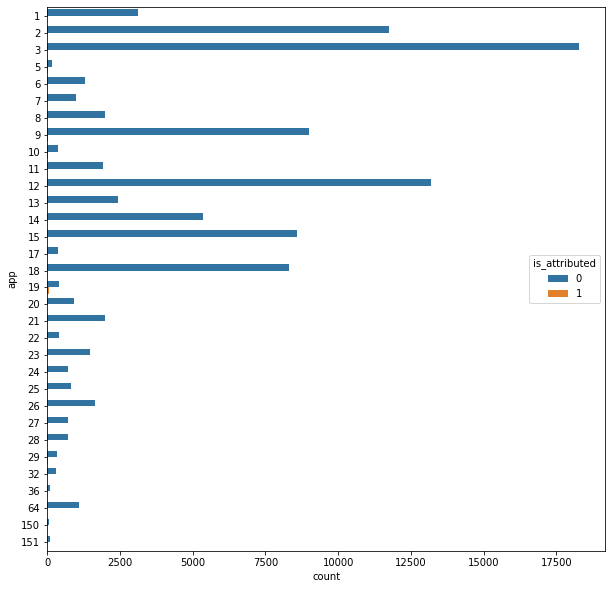

In [29]:
plt.figure(figsize=(10,10))
sns.countplot(data=fre_app,y="app",hue="is_attributed")


You can do lots of other interesting ananlysis with the existing features. For now, let's create some new features which will probably improve the model.

## Feature Engineering
Let's now derive some new features from the existing ones. There are a number of features one can extract from click_time itself, and by grouping combinations of IP with other features.

## Datetime Based Features

In [30]:
import datetime as dt

In [31]:
# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df
def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df["day_of_year"] = df["datetime"].dt.dayofyear
    df["month"] = df["datetime"].dt.month
    df["hour"] = df["datetime"].dt.hour
    return df

In [32]:
# creating new datetime variables and dropping the old ones
df=timeFeatures(df)

In [33]:
df.head()

,ip,app,device,os,channel,click_time,is_attributed,datetime,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,2017-11-07 09:30:38,0,2017-11-07 09:30:38,1,311,11,9
1,40024,25,1,17,259,2017-11-07 13:40:27,0,2017-11-07 13:40:27,1,311,11,13
2,35888,12,1,19,212,2017-11-07 18:05:24,0,2017-11-07 18:05:24,1,311,11,18
3,29048,13,1,13,477,2017-11-07 04:58:08,0,2017-11-07 04:58:08,1,311,11,4
4,2877,12,1,1,178,2017-11-09 09:00:09,0,2017-11-09 09:00:09,3,313,11,9


In [34]:
df.drop(["click_time","datetime"],inplace=True,axis=1)

In [35]:
df.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   is_attributed  100000 non-null  uint8 
 6   day_of_week    100000 non-null  int64 
 7   day_of_year    100000 non-null  int64 
 8   month          100000 non-null  int64 
 9   hour           100000 non-null  int64 
dtypes: int64(4), uint16(5), uint8(1)
memory usage: 4.1 MB


In [37]:
# memory used by training data
print('Training dataset uses {0} MB'.format(df.memory_usage().sum()/1024**2))

Training dataset uses 4.100921630859375 MB


In [38]:
# lets convert the variables back to lower dtype again
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
df[int_vars] = df[int_vars].astype('uint16')

In [39]:
# memory used by training data
print('Training dataset uses {0} MB'.format(df.memory_usage().sum()/1024**2))

Training dataset uses 1.812103271484375 MB


### IP Grouping Based Features
Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

In [40]:
ip_count=df.groupby("ip").size().reset_index(name="ip_count").astype("int16")
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc.

The following function takes in a dataframe and creates these features.

In [41]:
df.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [42]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df_1):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df_1
    df_1=pd.merge(df_1,ip_count,on="ip",how="left")
    del ip_count
    df_1 = pd.merge(df_1, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df_1 = pd.merge(df_1, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df_1 = pd.merge(df_1, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df_1 = pd.merge(df_1, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df_1 = pd.merge(df_1, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df_1

In [43]:
df=grouped_features(df)

In [44]:
df.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [45]:
print('Training dataset uses {0} MB'.format(df.memory_usage().sum()/1024**2))

Training dataset uses 3.719329833984375 MB


In [46]:
# garbage collect (unused) object
gc.collect()

95

## Modelling

Let's now build models to predict the variable ```is_attributed``` (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost), tune the hyperparameters in each model and choose the one which gives the best performance.

In the original Kaggle competition, the metric for model evaluation is **area under the ROC curve**.

In [47]:
# create x and y train
X = df.drop('is_attributed', axis=1)
y = df[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [48]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


# AdaBoost

In [49]:
# adaboost classifier with max 600 decision trees of depth=2
# learning_rate/shrinkage=1.5

# base estimator
tree = DecisionTreeClassifier(max_depth=2)
# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(base_estimator=tree,n_estimators=100,learning_rate=1.5,algorithm="SAMME")

In [50]:
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [51]:
# predictions
# the second column represents the probability of a click resulting in a download
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.57980968, 0.42019032],
       [0.57026291, 0.42973709],
       [0.57658083, 0.42341917],
       [0.52546509, 0.47453491],
       [0.53487777, 0.46512223],
       [0.56119995, 0.43880005],
       [0.55475869, 0.44524131],
       [0.56821366, 0.43178634],
       [0.5451816 , 0.4548184 ],
       [0.52738103, 0.47261897]])

## It gives two output because
**it mean, the probability of occurance of 0 is 0.57980968 and 1 is 0.42019032**
* As  target variable is classification problem having two output

In [52]:
predictions[:,1]

array([0.42019032, 0.42973709, 0.42341917, ..., 0.47710562, 0.46313199,
       0.46080039])

In [53]:
# metrics: AUC
metrics.roc_auc_score(y_test, predictions[:,1])

0.9504819176480415

### AdaBoost - Hyperparameter Tuning

Let's now tune the hyperparameters of the AdaBoost classifier. In this case, we have two types of hyperparameters - those of the component trees (max_depth etc.) and those of the ensemble (n_estimators, learning_rate etc.). 


We can tune both using the following technique - the keys of the form ```base_estimator_parameter_name``` belong to the trees (base estimator), and the rest belong to the ensemble.

In [54]:
# parameter grid
param_grid = {"base_estimator__max_depth":[2,5],
              "n_estimators":[100,150,200]
    
}

In [55]:
tree=DecisionTreeClassifier()
# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6, we'll discuss learning_rate below
ABC = AdaBoostClassifier(tree,learning_rate=0.6,algorithm="SAMME")

In [56]:
# run grid search
folds = 3
grid_search_ABC = GridSearchCV(ABC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [57]:
# fit 
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [61]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.254807,0.295188,0.411871,0.023518,2,100,"{'base_estimator__max_depth': 2, 'n_estimators...",0.925026,0.974845,0.950067,0.949979,0.020339,3,0.994749,0.990833,0.993178,0.992920,0.001609
1,14.278219,0.911315,0.613283,0.020478,2,150,"{'base_estimator__max_depth': 2, 'n_estimators...",0.928443,0.976389,0.955195,0.953343,0.019618,1,0.995452,0.993959,0.995626,0.995012,0.000748
2,19.025034,0.323141,0.794748,0.022835,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,2,0.996306,0.995094,0.996461,0.995954,0.000611
3,20.038511,0.777652,0.524587,0.031389,5,100,"{'base_estimator__max_depth': 5, 'n_estimators...",0.906216,0.940587,0.941023,0.929276,0.016306,5,1.000000,0.999997,1.000000,0.999999,0.000001
4,30.679310,0.421143,0.695089,0.008213,5,150,"{'base_estimator__max_depth': 5, 'n_estimators...",0.905705,0.946565,0.938713,0.930328,0.017704,4,1.000000,1.000000,1.000000,1.000000,0.000000
5,40.590998,0.409298,0.963323,0.034062,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.902318,0.940108,0.937281,0.926569,0.017187,6,1.000000,1.000000,1.000000,1.000000,0.000000


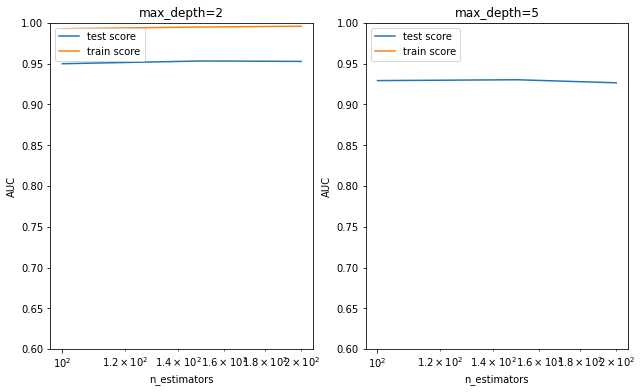

In [62]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]

    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

    

The results above show that:

The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score
Thus, we should go ahead with max_depth=2 and n_estimators=200.

Note that we haven't experimented with many other important hyperparameters till now, such as learning rate, subsample etc., and the results might be considerably improved by tuning them. We'll next experiment with these hyperparameters.

In [64]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC = AdaBoostClassifier(base_estimator=tree, learning_rate=0.6,n_estimators=200,algorithm="SAMME")
ABC.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [65]:
# predict on test data
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.61058431, 0.38941569],
       [0.60742586, 0.39257414],
       [0.63265753, 0.36734247],
       [0.58758342, 0.41241658],
       [0.57045678, 0.42954322],
       [0.61162484, 0.38837516],
       [0.59403993, 0.40596007],
       [0.60805124, 0.39194876],
       [0.60362848, 0.39637152],
       [0.57654304, 0.42345696]])

In [69]:
# roc auc
metrics.roc_auc_score(y_test,predictions[:,1])

0.960727748545338

# Gradient Boosting Classifier

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - learning_rate (shrinkage) and subsample.

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between learning_rate and n_estimators - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting subsample to less than 1), we can have the individual models built on random subsamples of size subsample. That way, each tree will be trained on different subsets and reduce the model's variance.

In [70]:
# parameter grid
param_grid = {"learning_rate": [0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

In [71]:
# adaboost with the tree as base estimator
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [77]:
# run grid search
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
         

In [78]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.470299,0.221546,0.096317,0.017742,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.730088,0.847697,0.749365,0.775717,0.051503,4,0.655534,0.817064,0.702921,0.725173,0.067795
1,14.095470,0.450714,0.090650,0.009980,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.776209,0.921150,0.766698,0.821353,0.070674,2,0.829879,0.918936,0.740541,0.829785,0.072829
2,18.185591,2.073511,0.098239,0.015291,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.835166,0.792362,0.867276,0.831601,0.030687,1,0.849417,0.789686,0.842924,0.827343,0.026759
3,9.184912,0.392425,0.087319,0.006236,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.647689,0.681823,0.618392,0.649301,0.025921,5,0.580977,0.688896,0.643714,0.637862,0.044252
4,13.999895,0.075613,0.088188,0.002451,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.650743,0.614298,0.336963,0.534001,0.140120,7,0.615614,0.656000,0.366851,0.546155,0.127855


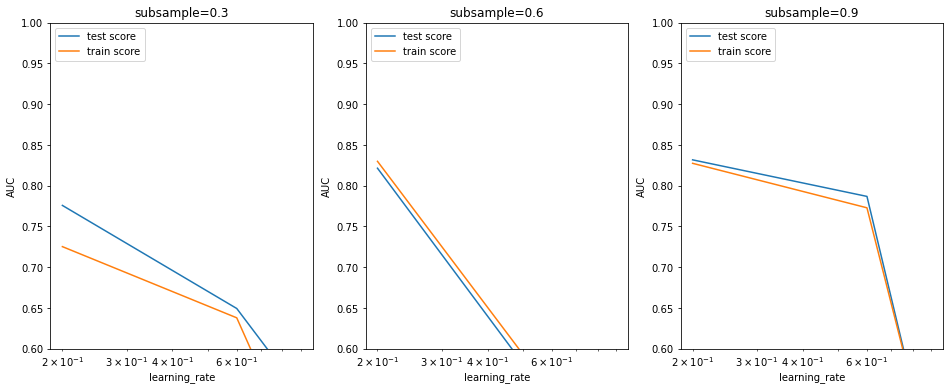

In [79]:
# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit.

Also, a lower learning rate results in less overfitting.

# XGBoost
Let's finally try XGBoost. The hyperparameters are the same, some important ones being subsample, learning_rate, max_depth etc.

In [80]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

[14:59:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [81]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

In [82]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 96.06%


The roc_auc in this case is about 0.95% with default hyperparameters. Let's try changing the hyperparameters - an exhaustive list of XGBoost hyperparameters is here: http://xgboost.readthedocs.io/en/latest/parameter.html

Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

In [83]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [84]:
# fit the model
model_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[15:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.7min finished


[15:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_cons...
                                     predictor=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_

In [85]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.190509,0.245743,0.075040,0.012310,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,5.821962,0.460833,0.082276,0.016871,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,5.404250,0.467437,0.060343,0.002174,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,4.985763,0.013272,0.064101,0.000858,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,5.680989,0.456748,0.076627,0.014282,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744
5,5.122167,0.272877,0.062437,0.000593,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.923785,0.975658,0.947313,0.948919,0.021207,4,0.999633,0.999070,0.999660,0.999454,0.000272


In [87]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
#cv_results['param_max_depth'] = cv_results['param_max_depth'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.190509,0.245743,0.075040,0.012310,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,5.821962,0.460833,0.082276,0.016871,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,5.404250,0.467437,0.060343,0.002174,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,4.985763,0.013272,0.064101,0.000858,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,5.680989,0.456748,0.076627,0.014282,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744


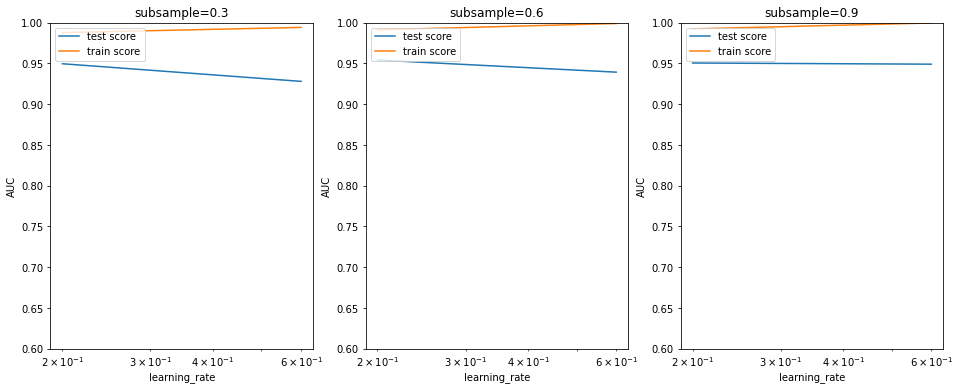

In [88]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

The results show that a subsample size of 0.6 and learning_rate of about 0.2 seems optimal. Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters).

Let's build a final model with the chosen hyperparameters.

In [89]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

[15:05:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:05:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, ...)

In [90]:
# predict
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [91]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc


0.9606303070798186

Finally, let's also look at the feature importances

In [92]:
# feature importance
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.047281995,
 'app': 0.17046945,
 'device': 0.22968191,
 'os': 0.08196739,
 'channel': 0.15076274,
 'day_of_week': 0.05127023,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.04917619,
 'ip_count': 0.072104864,
 'ip_day_hour': 0.042323995,
 'ip_hour_channel': 0.0,
 'ip_hour_os': 0.040770125,
 'ip_hour_app': 0.026437322,
 'ip_hour_device': 0.037753765}

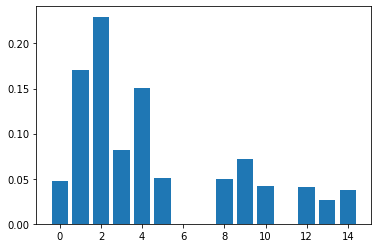

In [93]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

## Predictions on Test Data

Since this problem is hosted on Kaggle, you can  choose to make predictions on the test data and submit your results. Please note the following points and recommendations if you go ahead with Kaggle:

Recommendations for training:
- We have used only a fraction of the training set (train_sample, 100k rows), the full training data on Kaggle (train.csv) has about 180 million rows. You'll get good results only if you train the model on a significant portion of the training dataset.  
- Because of the size, you'll need to use Kaggle kernels to train the model on full training data. Kaggle kernels provide powerful computation capacities on cloud (for free). 
- Even on the kernel, you may need to use a portion of the training dataset (try using the last 20-30 million rows).
- Make sure you save memory by following some tricks and best practices, else you won't be able to train the model at all on a large dataset.
